# Project 1 Neuronal networks

## 1.- MNIST and FMINST datasets

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [3]:
# !pip install wandb
import wandb # Weight & Biases library to monitor training and compare models
wandb.login() # API key: 569de9861dbe18fe8888f13ca66e39d2b12934ff

/home/vm/anaconda3/lib/python3.11/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alejogonzalez9 (zurdito). Use `wandb login --relogin` to force relogin


True

To obtain the MNIST dataset:

In [4]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainsetMNIST = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
train_MNIST = torch.utils.data.DataLoader(trainsetMNIST, batch_size=64, shuffle=True)

# Download and load the test data
testsetMNIST = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
test_MNIST = torch.utils.data.DataLoader(testsetMNIST, batch_size=64, shuffle=True)

To obtain the FMINST dataset:

In [5]:

# Download and load the training data
trainsetFMNIST = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
train_FMNIST = torch.utils.data.DataLoader(trainsetFMNIST, batch_size=64, shuffle=True)

# Download and load the test data
testsetFMNIST = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
test_FMNIST = torch.utils.data.DataLoader(testsetFMNIST, batch_size=64, shuffle=True)

In [6]:
dataiter = iter(train_MNIST)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
print(torch.min(images), torch.max(images))

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


In [7]:
dataiter = iter(train_FMNIST)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
print(torch.min(images), torch.max(images))

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


We can see that our images are of size 28 x 28 = 784, so the input layer is of size 784. It is important to see that the range of the values are -1,1 so for the output layer we will use the tanh.

We also need to split the training data into training and validation sets.

In [8]:
import copy


valid_MNIST = copy.deepcopy(train_MNIST)  # Creates a copy of the object

#We take the first 45k images for training
train_MNIST.dataset.data = train_MNIST.dataset.data[:45000,:,:]

#And the rest for validation
valid_MNIST.dataset.data = valid_MNIST.dataset.data[45000:,:,:]




In [9]:
import copy

valid_FMNIST = copy.deepcopy(train_FMNIST)  # Creates a copy of the object

#We take the first 45k images for training
train_FMNIST.dataset.data = train_FMNIST.dataset.data[:45000,:,:]

#And the rest for validation
valid_FMNIST.dataset.data = valid_FMNIST.dataset.data[45000:,:,:]

Select Data Set To Be Trained: 

In [10]:
INDEX = 1 # INDEX = 0 for MNIST and 1 for FMNIST!

train_set = [train_MNIST, train_FMNIST]
valid_set = [valid_MNIST, valid_FMNIST]
test_set = [test_MNIST, test_FMNIST]

print( train_set[0].dataset.data.shape, train_set[1].dataset.data.shape)
print( valid_set[0].dataset.data.shape, valid_set[1].dataset.data.shape)
print( test_set[0].dataset.data.shape, test_set[1].dataset.data.shape)

torch.Size([45000, 28, 28]) torch.Size([45000, 28, 28])
torch.Size([15000, 28, 28]) torch.Size([15000, 28, 28])
torch.Size([10000, 28, 28]) torch.Size([10000, 28, 28])


## 3 layers at both encoder/decoder:


In [11]:

class autoencoder3(nn.Module):
    def __init__(self, projected_dimension):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001
 
        if INDEX == 0:  # MNIST
            self.name_train = f"3_layer_with_PSNR_train_MNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_with_PSNR_test_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif INDEX == 1:  # FMNIST
            self.name_train = f"3_layer_with_PSNR_train_FMNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_with_PSNR_test_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder3, INDEX should be either 0 or 1.")
        
        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []



        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(self.input_image_size, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2), # Dropout with a probability of 0.2
            nn.Linear(300, 150),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(150, self.projected_dimension),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(self.projected_dimension, 150),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(150, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300, self.input_image_size),
            nn.Tanh(),
        )
        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()




        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img = img.reshape(-1, self.input_image_size)
                reconstructed = self.forward(img)
                loss_train = self.criterion(reconstructed, img)

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    images = images.reshape(-1, self.input_image_size)

                    out = self.forward(images)

                    loss_valid = self.criterion(out,images)

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": projected_dimensions[run], "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((projected_dimensions[run], epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance

Definition of parameters of the model and Peak signal-to-noise ratio (PSNR)

Training the model

In [12]:
projected_dimensions = [15, 30, 50, 100] # This are the dimensions we are going to project the data into
epochs = 30
models_autoencoder3 = []
for run in range(len(projected_dimensions)):
    model = autoencoder3(projected_dimensions[run])  # To initialize the model with the projected dimension
    model.do_training(epochs,train_set[INDEX],valid_set[INDEX])
    models_autoencoder3.append(model)

Epoch:  1 Loss train:  0.10093501372135837 , Loss valid:  0.06969078451077988
Epoch:  2 Loss train:  0.06183095460503616 , Loss valid:  0.0580323689319986
Epoch:  3 Loss train:  0.05453343867239627 , Loss valid:  0.05334885115636156
Epoch:  4 Loss train:  0.05078047010730105 , Loss valid:  0.05100703261634137
Epoch:  5 Loss train:  0.04873445853908462 , Loss valid:  0.04943971006160087
Epoch:  6 Loss train:  0.047288637830537154 , Loss valid:  0.04817242700051754
Epoch:  7 Loss train:  0.04618375134569677 , Loss valid:  0.047594073525768645
Epoch:  8 Loss train:  0.04527394101288254 , Loss valid:  0.046496194838843444
Epoch:  9 Loss train:  0.04458635651760481 , Loss valid:  0.046249489565478995
Epoch:  10 Loss train:  0.04401939305667342 , Loss valid:  0.045532783580587266
Epoch:  11 Loss train:  0.04361037613125518 , Loss valid:  0.04567747915044744
Epoch:  12 Loss train:  0.043095119276338 , Loss valid:  0.04452026529197997
Epoch:  13 Loss train:  0.04265538369707594 , Loss valid:  

Loss train,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.03956
Loss valid,0.04321
projected dimension,15


Epoch:  1 Loss train:  0.09886876588941297 , Loss valid:  0.06791270067717167
Epoch:  2 Loss train:  0.06008201562905346 , Loss valid:  0.056078408927993574
Epoch:  3 Loss train:  0.05186018600678918 , Loss valid:  0.05155894669129493
Epoch:  4 Loss train:  0.04747018112737516 , Loss valid:  0.04717136470878378
Epoch:  5 Loss train:  0.044581929406955496 , Loss valid:  0.046331007715235364
Epoch:  6 Loss train:  0.04258497786941007 , Loss valid:  0.04326415990895413
Epoch:  7 Loss train:  0.04098391939557835 , Loss valid:  0.041681579215095396
Epoch:  8 Loss train:  0.0396974887937011 , Loss valid:  0.04159437438591998
Epoch:  9 Loss train:  0.03866967782695693 , Loss valid:  0.03965584193455412
Epoch:  10 Loss train:  0.037968675714430654 , Loss valid:  0.040067083895840544
Epoch:  11 Loss train:  0.03729852229430848 , Loss valid:  0.03870173533387641
Epoch:  12 Loss train:  0.036619558771648866 , Loss valid:  0.038624830472659556
Epoch:  13 Loss train:  0.03622170414415781 , Loss val

Loss train,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▅▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.03247
Loss valid,0.03512
projected dimension,30


Epoch:  1 Loss train:  0.09803022513039071 , Loss valid:  0.06792508991474801
Epoch:  2 Loss train:  0.05926778514086353 , Loss valid:  0.05448909010341827
Epoch:  3 Loss train:  0.050524655935904855 , Loss valid:  0.04918314074265196
Epoch:  4 Loss train:  0.04616966214433143 , Loss valid:  0.0459533081251256
Epoch:  5 Loss train:  0.043256131776037036 , Loss valid:  0.04306322410702705
Epoch:  6 Loss train:  0.04097669810818678 , Loss valid:  0.042398086681644964
Epoch:  7 Loss train:  0.03937871239031665 , Loss valid:  0.04115950252781523
Epoch:  8 Loss train:  0.038022933771241114 , Loss valid:  0.03891861416558002
Epoch:  9 Loss train:  0.03681407942150889 , Loss valid:  0.037891703423984506
Epoch:  10 Loss train:  0.035813814039680765 , Loss valid:  0.037368630229475654
Epoch:  11 Loss train:  0.03496566302386451 , Loss valid:  0.0365831834442438
Epoch:  12 Loss train:  0.03422409507964568 , Loss valid:  0.03633520275037339
Epoch:  13 Loss train:  0.033464707420948384 , Loss vali

Loss train,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.02812
Loss valid,0.0304
projected dimension,50


Epoch:  1 Loss train:  0.09867560863494873 , Loss valid:  0.06703587978127155
Epoch:  2 Loss train:  0.05905152365713465 , Loss valid:  0.05612209770590701
Epoch:  3 Loss train:  0.050731822795403954 , Loss valid:  0.05002743974328041
Epoch:  4 Loss train:  0.0458413627453741 , Loss valid:  0.04630558484412254
Epoch:  5 Loss train:  0.04270783428695391 , Loss valid:  0.04300375885151802
Epoch:  6 Loss train:  0.040353342967467724 , Loss valid:  0.0408170703719271
Epoch:  7 Loss train:  0.038584830771221525 , Loss valid:  0.039373401362211145
Epoch:  8 Loss train:  0.037013892624103886 , Loss valid:  0.03895471310044857
Epoch:  9 Loss train:  0.035859521822368894 , Loss valid:  0.0379014623608995
Epoch:  10 Loss train:  0.03485346663298763 , Loss valid:  0.035626725210471354
Epoch:  11 Loss train:  0.033855348275127733 , Loss valid:  0.0357736772679268
Epoch:  12 Loss train:  0.0330562902752056 , Loss valid:  0.03473126815354571
Epoch:  13 Loss train:  0.03237308374743655 , Loss valid: 

Loss train,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.02572
Loss valid,0.02774
projected dimension,100


Performance of the model

In [13]:
model.eval_performance(test_valid[INDEX])

tensor(15.1564)

Visualization of reconstructed images

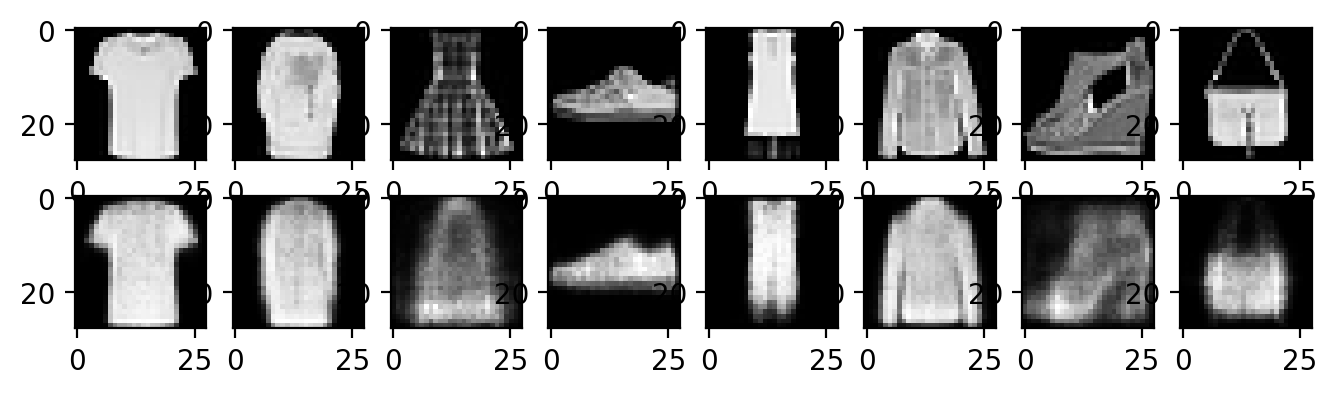

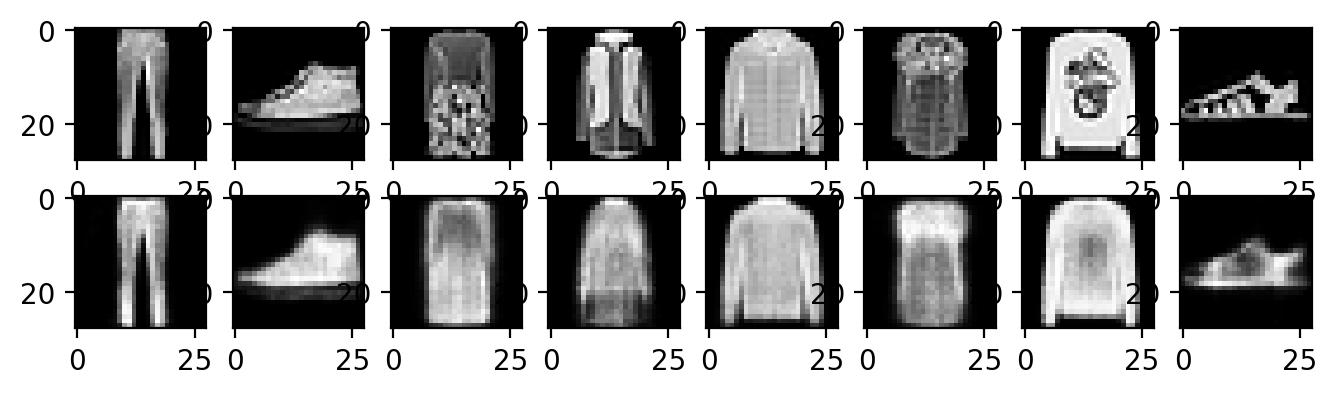

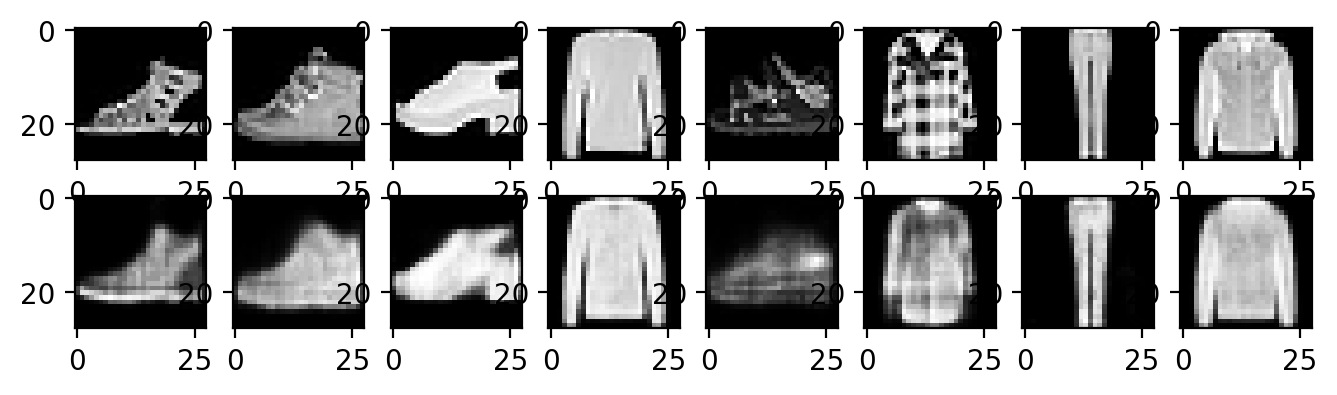

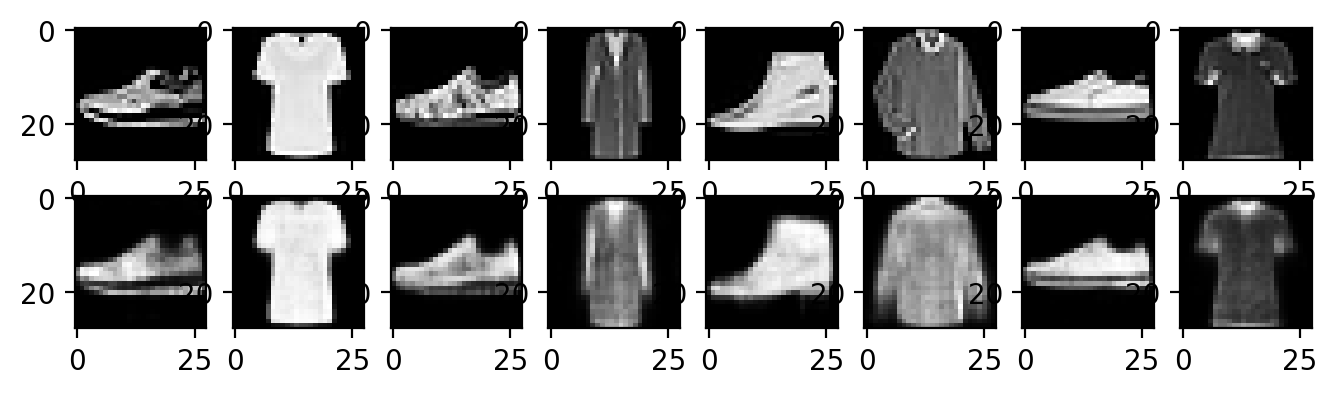

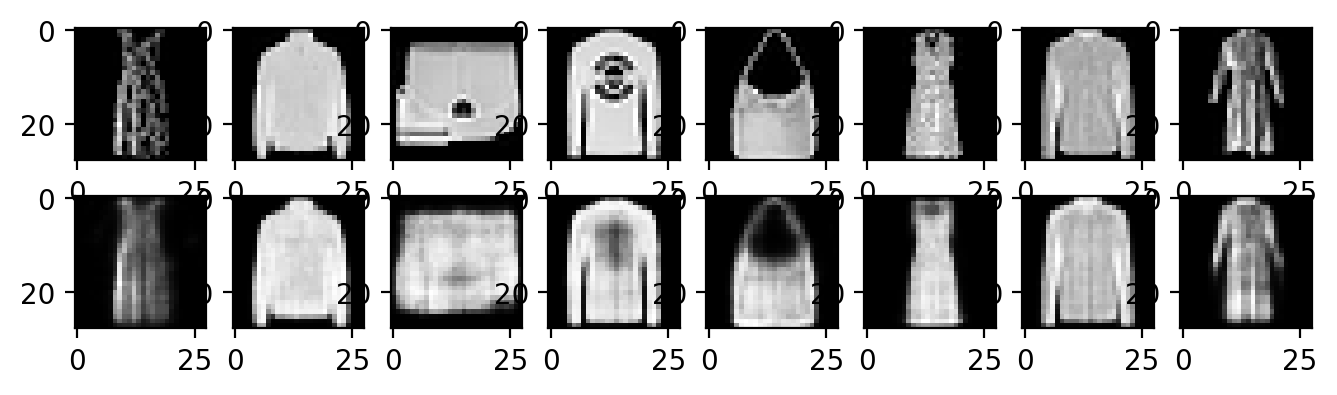

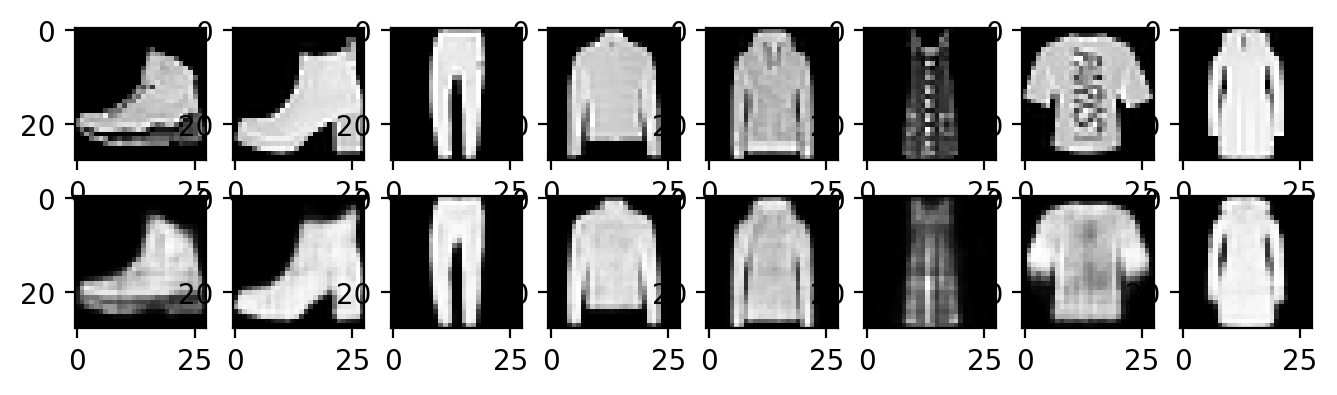

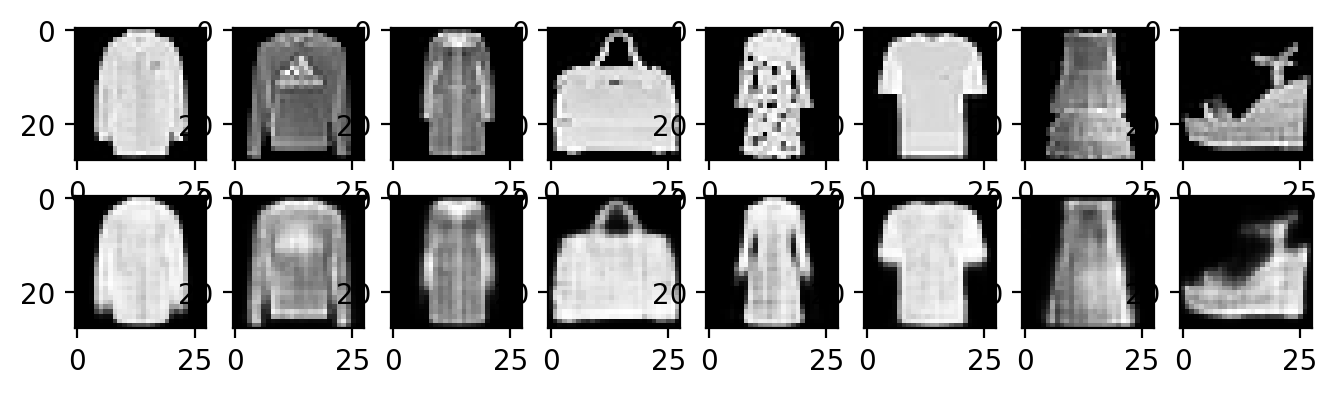

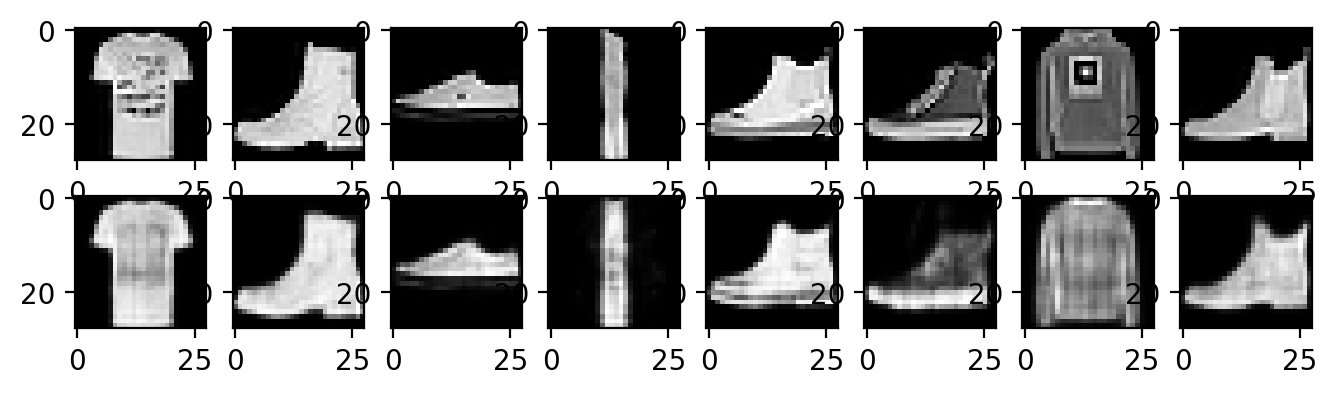

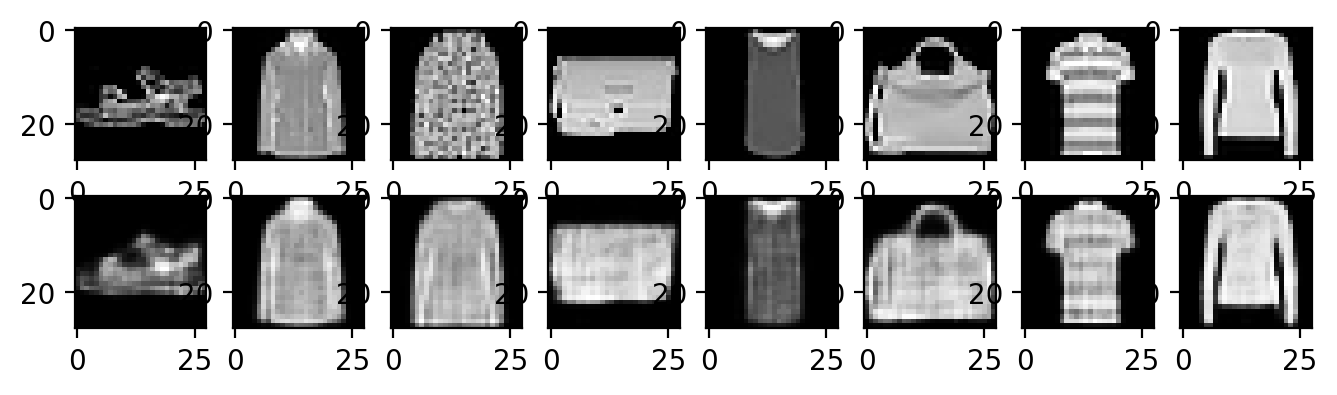

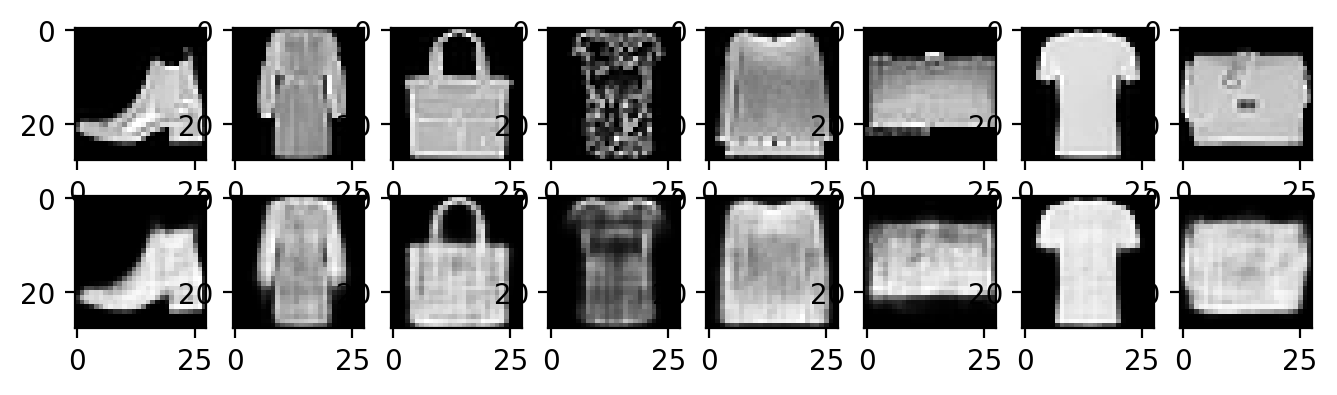

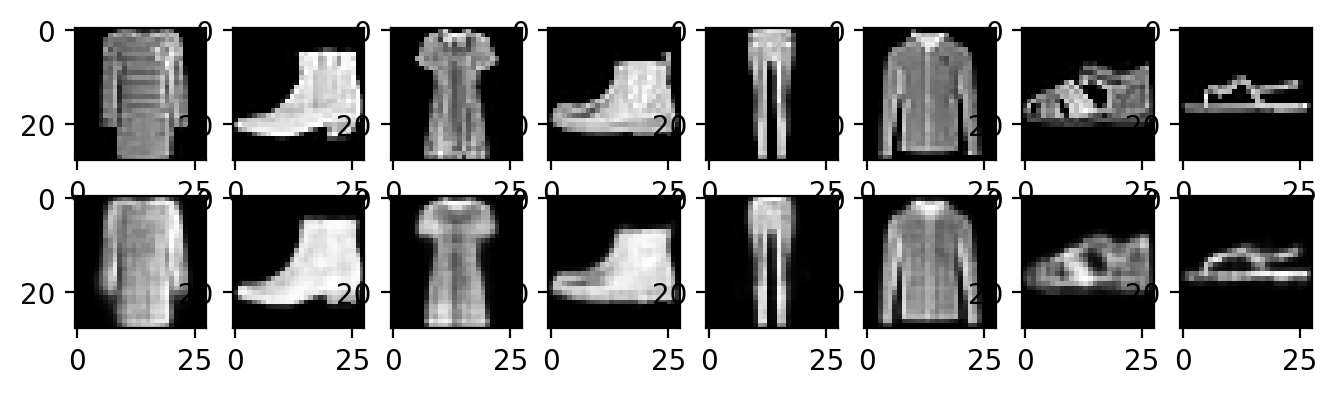

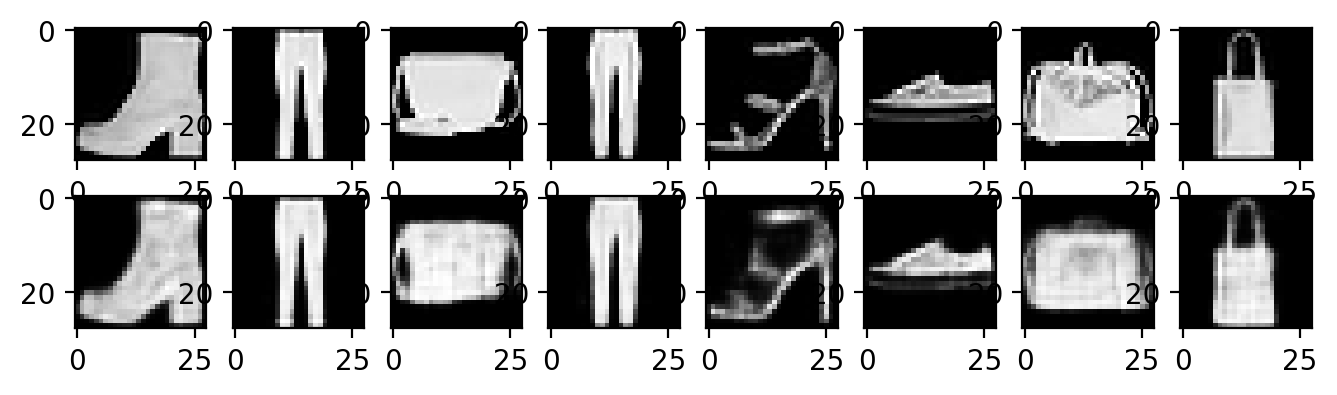

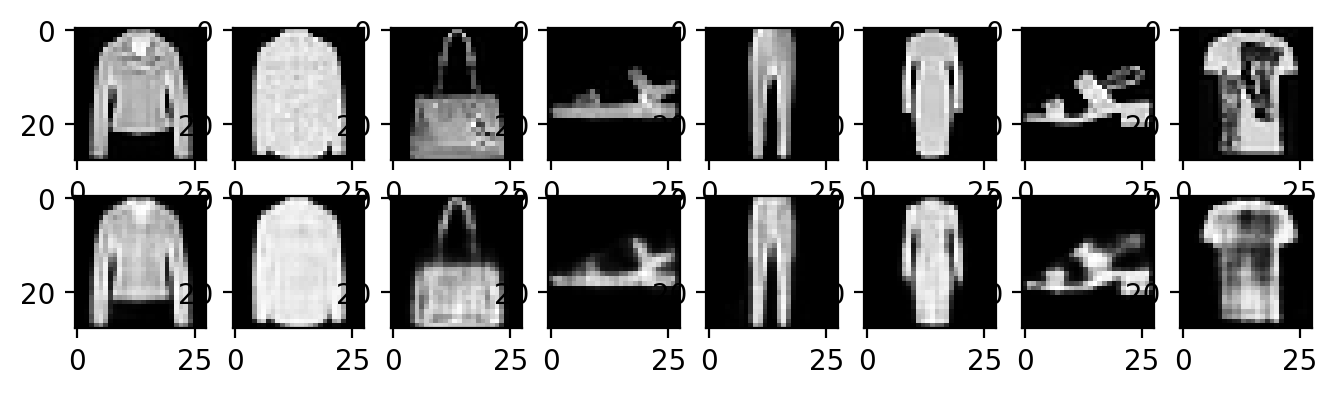

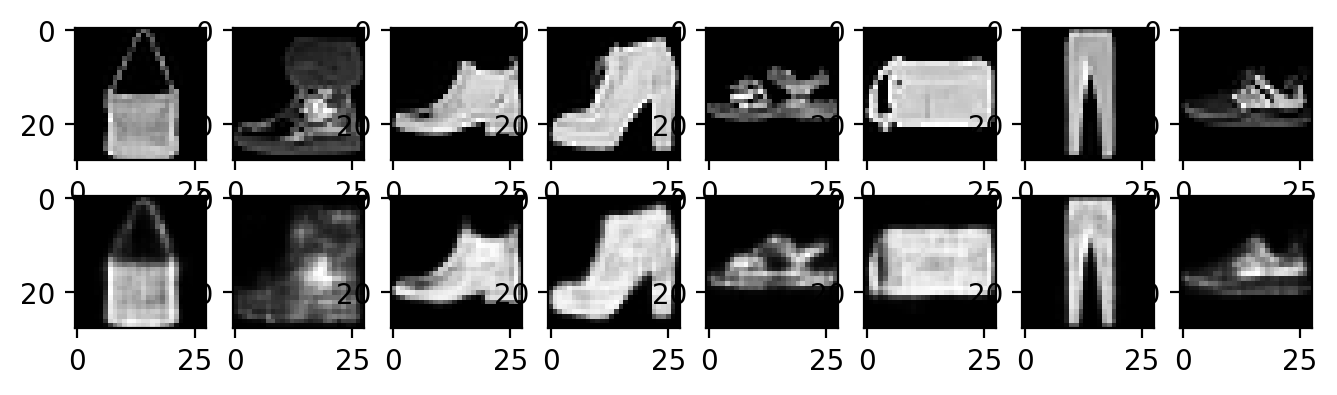

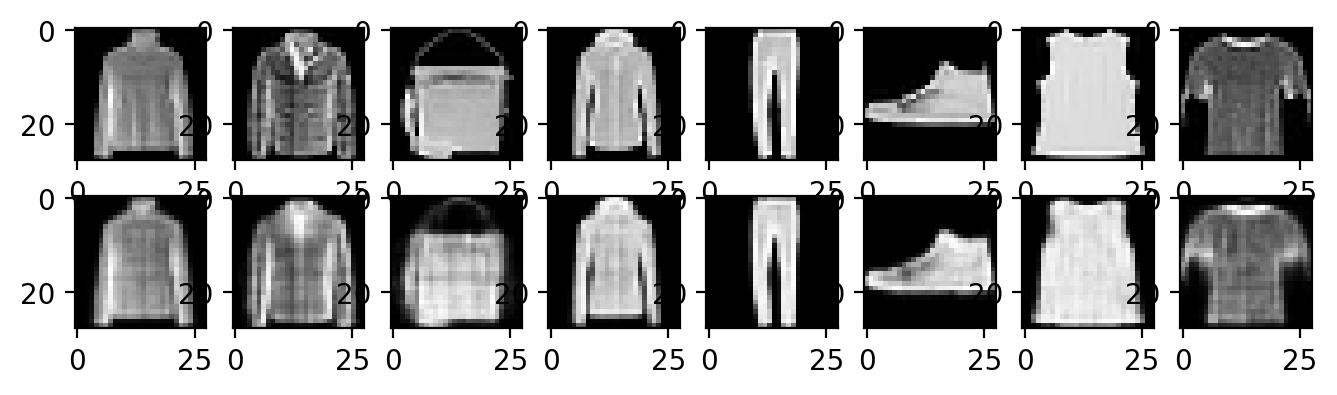

In [14]:
for k in range(0,epochs,2):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs = model.outputs[k][2].detach().numpy()
  recon = model.outputs[k][3].detach().numpy()
  for i, item in enumerate(imgs):
    if i >=9: break
    plt.subplot(2,9,i+1)
    item = item.reshape(-1,28,28)

    plt.imshow(item[0])
  for i, item in enumerate(recon):
    if i >=9: break
    plt.subplot(2,9,i+1+9)
    item = item.reshape(-1,28,28)

    plt.imshow(item[0])



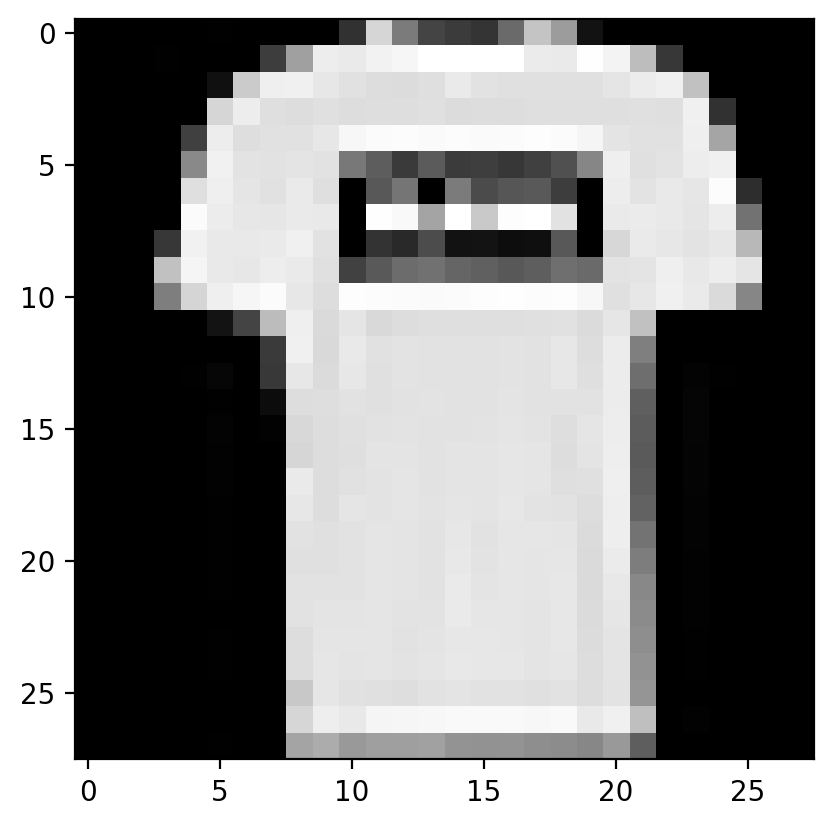

In [15]:
# Adding noise
def add_noise(img, variance):
    noise = np.random.normal(loc=0, scale=np.sqrt(variance), size=img.shape)
    return img + noise
img = train_set[INDEX].dataset.data[1,:,:]
noised_img = add_noise(img, 100)
plt.imshow(img.numpy().reshape([28,28]), cmap='Greys_r')

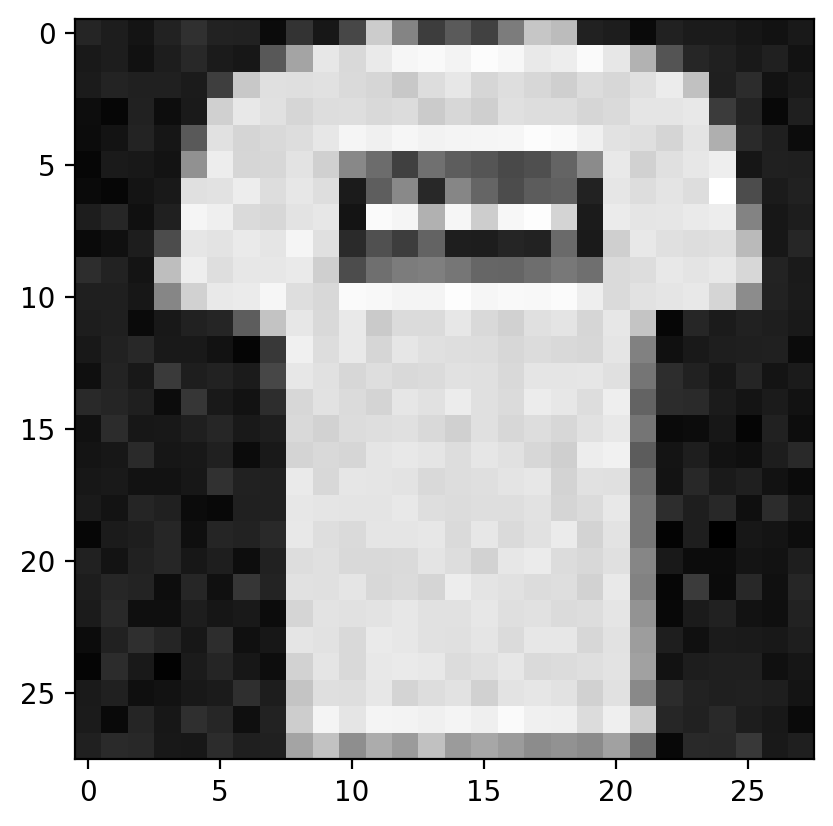

In [16]:
plt.imshow(noised_img.numpy().reshape([28,28]), cmap='Greys_r')

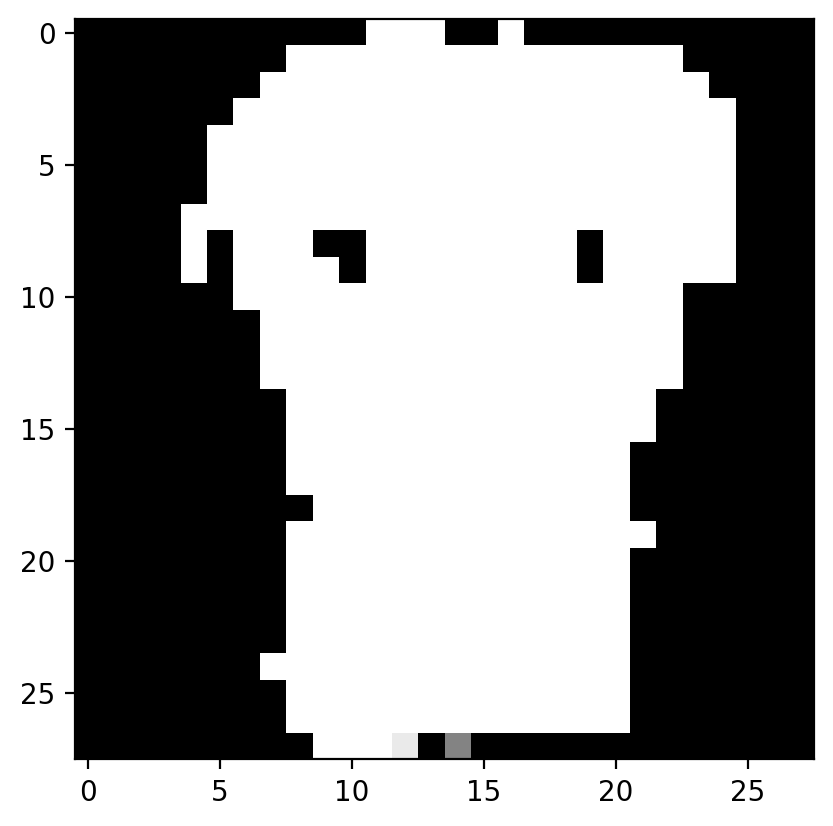

In [17]:
noised_img = noised_img.reshape(-1, 784)
reconstructed = models_autoencoder3[-1].forward(noised_img.float())
plt.imshow(reconstructed.detach().numpy().reshape([28,28]))

# 5 layers at both encoder/decoder:

In [18]:
class autoencoder5(nn.Module):
    def __init__(self,projected_dimension):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001

        if INDEX == 0:  # MNIST
            self.name_train = f"5_layer_with_PSNR_train_MNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_with_PSNR_test_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif INDEX == 1:  # FMNIST
            self.name_train = f"5_layer_with_PSNR_train_FMNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_with_PSNR_test_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder5, INDEX should be either 0 or 1.")


        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(784, 550),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(550, 400),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(400, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300,200),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(200,projected_dimension)
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(projected_dimension, 200),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(200, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300, 400),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(400,550),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(550,784),
            nn.Tanh()
        )

        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()


        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img = img.reshape(-1, self.input_image_size)
                reconstructed = model.forward(img)
                loss_train = self.criterion(reconstructed, img)

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    images = images.reshape(-1, self.input_image_size)

                    out = self.forward(images)

                    loss_valid = self.criterion(out,images)

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": projected_dimensions[run], "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((projected_dimensions[run], epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance

In [19]:
projected_dimensions = [15, 30, 50, 100]
epochs = 30
models_autoencoder5 = []
for run in range(len(projected_dimensions)):
    model = autoencoder5(projected_dimensions[run])  # To initialize the model with the projected dimension
    model.do_training(epochs,train_set[INDEX], valid_set[INDEX])
    models_autoencoder5.append(model)

Epoch:  1 Loss train:  0.13420527273873714 , Loss valid:  0.09203528616022556
Epoch:  2 Loss train:  0.08486607714175162 , Loss valid:  0.08394177308742036
Epoch:  3 Loss train:  0.07778332306241448 , Loss valid:  0.07804355186984895
Epoch:  4 Loss train:  0.06981404827886516 , Loss valid:  0.06896227193956679
Epoch:  5 Loss train:  0.0654286968532357 , Loss valid:  0.064793492932903
Epoch:  6 Loss train:  0.06308569427875971 , Loss valid:  0.06472164747562814
Epoch:  7 Loss train:  0.06146953876172616 , Loss valid:  0.062126182685507104
Epoch:  8 Loss train:  0.06018413084199314 , Loss valid:  0.061290389410358796
Epoch:  9 Loss train:  0.05878203773913397 , Loss valid:  0.061320102484302315
Epoch:  10 Loss train:  0.05695003928320313 , Loss valid:  0.057691816779527255
Epoch:  11 Loss train:  0.055593662614807145 , Loss valid:  0.057063530892767805
Epoch:  12 Loss train:  0.05450922018446198 , Loss valid:  0.05597592554193862
Epoch:  13 Loss train:  0.053403962435285474 , Loss valid:

Loss train,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▇▆▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04533
Loss valid,0.0491
projected dimension,15


Epoch:  1 Loss train:  0.13975321769248694 , Loss valid:  0.09427258927137294
Epoch:  2 Loss train:  0.08599253155460412 , Loss valid:  0.08319856759081495
Epoch:  3 Loss train:  0.07930308988910507 , Loss valid:  0.07679916078105886
Epoch:  4 Loss train:  0.07407761825015768 , Loss valid:  0.07328597532307848
Epoch:  5 Loss train:  0.07056966944153166 , Loss valid:  0.0691469983376087
Epoch:  6 Loss train:  0.06698932811956514 , Loss valid:  0.06582546256324079
Epoch:  7 Loss train:  0.06414930435130373 , Loss valid:  0.06386561027549682
Epoch:  8 Loss train:  0.061906569960146124 , Loss valid:  0.0633568487427336
Epoch:  9 Loss train:  0.06078359992666678 , Loss valid:  0.06128210032239873
Epoch:  10 Loss train:  0.059214573993813246 , Loss valid:  0.06116166896325476
Epoch:  11 Loss train:  0.05771518492838368 , Loss valid:  0.05998191646438964
Epoch:  12 Loss train:  0.05663450400937687 , Loss valid:  0.05761599621557175
Epoch:  13 Loss train:  0.05517356487160379 , Loss valid:  0.

Loss train,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04582
Loss valid,0.04963
projected dimension,30


Epoch:  1 Loss train:  0.14047894934827293 , Loss valid:  0.09420910170103641
Epoch:  2 Loss train:  0.08528888866898011 , Loss valid:  0.08196947298785473
Epoch:  3 Loss train:  0.07723549526417628 , Loss valid:  0.07502652359135607
Epoch:  4 Loss train:  0.07165281936547464 , Loss valid:  0.07027855659735964
Epoch:  5 Loss train:  0.06701406689403071 , Loss valid:  0.06644536565909995
Epoch:  6 Loss train:  0.06420063810550015 , Loss valid:  0.06451715982340751
Epoch:  7 Loss train:  0.062440044664650814 , Loss valid:  0.06636120946483409
Epoch:  8 Loss train:  0.06112818462266163 , Loss valid:  0.06201868637445125
Epoch:  9 Loss train:  0.05970885071226142 , Loss valid:  0.06109163886372079
Epoch:  10 Loss train:  0.058670480486894536 , Loss valid:  0.06016764523501092
Epoch:  11 Loss train:  0.05743198454464701 , Loss valid:  0.06063037771493831
Epoch:  12 Loss train:  0.05632252272599461 , Loss valid:  0.05982916329769378
Epoch:  13 Loss train:  0.05539429872508415 , Loss valid:  

Loss train,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▆▅▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04705
Loss valid,0.05175
projected dimension,50


Epoch:  1 Loss train:  0.1452042133208703 , Loss valid:  0.09672303044415535
Epoch:  2 Loss train:  0.08810223293998702 , Loss valid:  0.08305752042760241
Epoch:  3 Loss train:  0.07790478955509818 , Loss valid:  0.07632304491831901
Epoch:  4 Loss train:  0.0726427162616429 , Loss valid:  0.07156159544878818
Epoch:  5 Loss train:  0.06809839250689204 , Loss valid:  0.06730373134004308
Epoch:  6 Loss train:  0.0645158910880458 , Loss valid:  0.0641687440745374
Epoch:  7 Loss train:  0.06163566143103791 , Loss valid:  0.061888129549457674
Epoch:  8 Loss train:  0.05986946721201424 , Loss valid:  0.05983098471101294
Epoch:  9 Loss train:  0.058445558020718054 , Loss valid:  0.060006006807088855
Epoch:  10 Loss train:  0.05735051389042796 , Loss valid:  0.0580310584224285
Epoch:  11 Loss train:  0.056077518209349364 , Loss valid:  0.05746461403496722
Epoch:  12 Loss train:  0.0552707690989006 , Loss valid:  0.05658439434272178
Epoch:  13 Loss train:  0.05423455307556486 , Loss valid:  0.05

Loss train,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss valid,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
projected dimension,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss train,0.04636
Loss valid,0.05061
projected dimension,100


# Save the models

In [20]:
if INDEX == 0:  # MNIST
  for i in range(len(models_autoencoder3)):
    torch.save(models_autoencoder3[i].state_dict(), f'model_autoencoder3_MNIST_{projected_dimensions[i]}.pth')
    torch.save(models_autoencoder5[i].state_dict(), f'model_autoencoder5_MNIST_{projected_dimensions[i]}.pth')
elif INDEX == 1:  # FMNIST
  for i in range(len(models_autoencoder3)):
    torch.save(models_autoencoder3[i].state_dict(), f'model_autoencoder3_FMNIST_{projected_dimensions[i]}.pth')
    torch.save(models_autoencoder5[i].state_dict(), f'model_autoencoder5_FMNIST_{projected_dimensions[i]}.pth')

else:
        raise ValueError("While saving the models, INDEX should be either 0 or 1.")

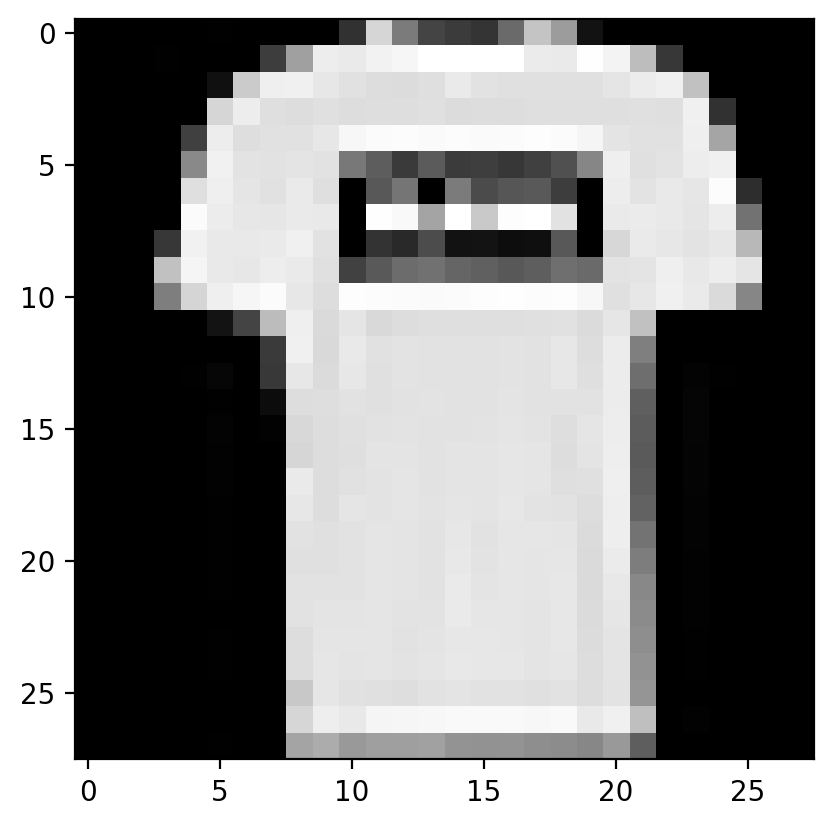

In [21]:
img = train_set[INDEX].dataset.data[1,:,:]
noised_img = add_noise(img, 100)
plt.imshow(img.numpy().reshape([28,28]), cmap='Greys_r')


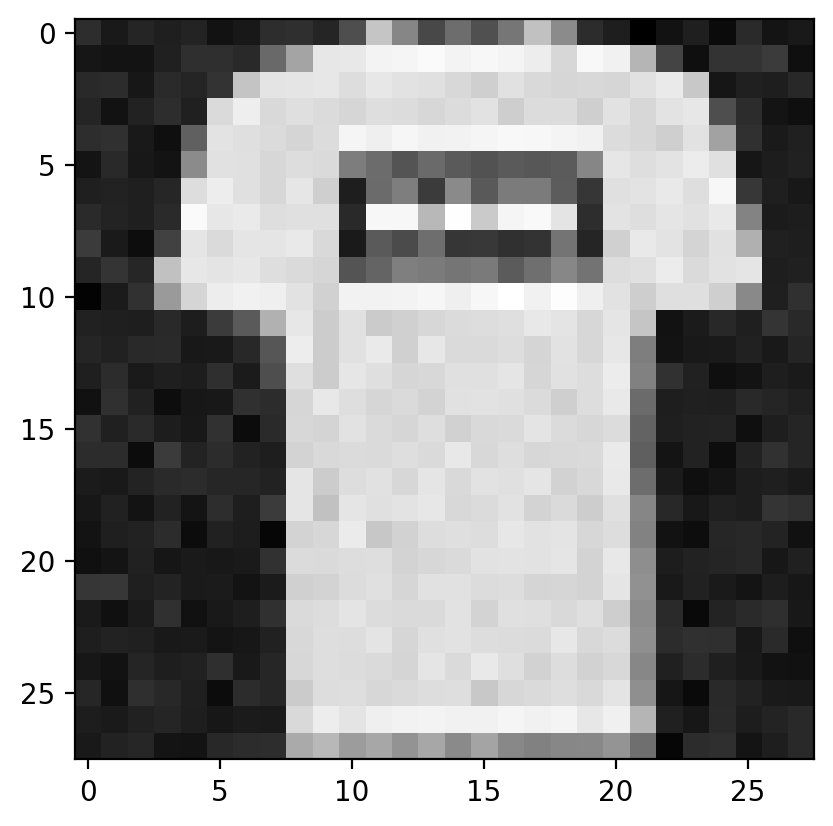

In [22]:
plt.imshow(noised_img.numpy().reshape([28,28]), cmap='Greys_r')

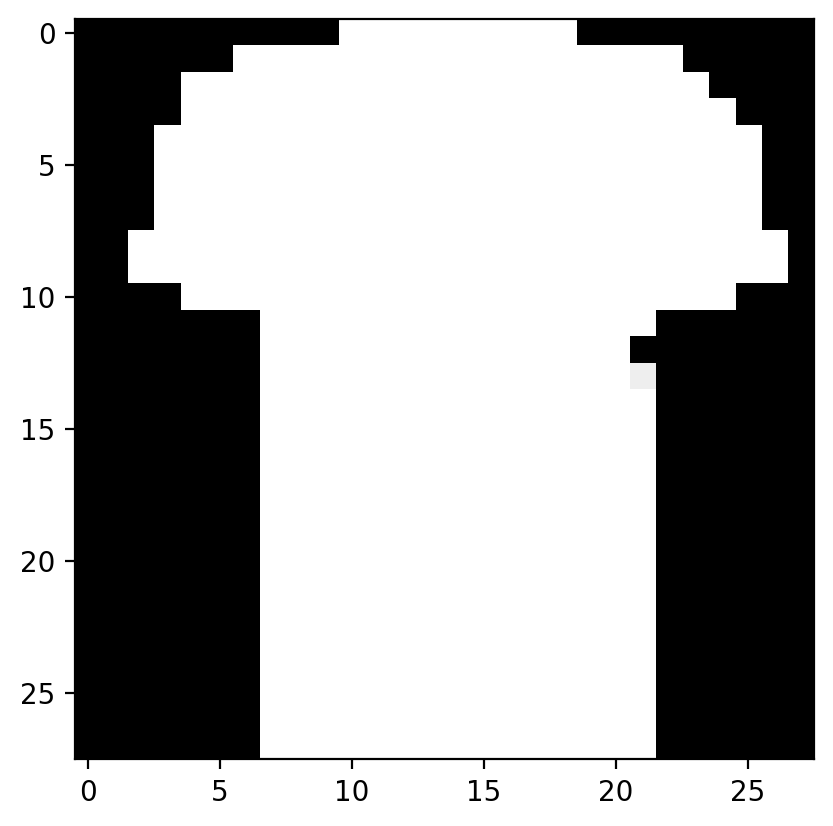

In [23]:
noised_img5 = noised_img.reshape(-1, 784)
reconstructed5 = models_autoencoder5[-1].forward(noised_img5.float())
plt.imshow(reconstructed5.detach().numpy().reshape([28,28]))

In [24]:
import torch
projected_dimensions = [15, 30, 50, 100] # This are the dimensions we are going to project the data into
models_autoencoder3 = []
models_autoencoder5 = []

if INDEX == 0:  # MNIST
  dataset0 = "MNIST"
else:
  dataset0 = "FMNIST"

for i in range(4):
    state_dict = torch.load(f'model_autoencoder3_{dataset0}_{projected_dimensions[i]}.pth')
    model_3 = autoencoder3(projected_dimensions[i])
    model_3.load_state_dict(state_dict)
    models_autoencoder3.append(model_3)

    state_dict = torch.load(f'model_autoencoder5_{dataset0}_{projected_dimensions[i]}.pth')
    model_5 = autoencoder5(projected_dimensions[i])
    model_5.load_state_dict(state_dict)
    models_autoencoder5.append(model_5)

In [25]:
def evaluate_model(models, train, valid, test):
    for n_layers in range(len(models)):
        for i, model in enumerate(models[n_layers]):
            n_lay = 3 if n_layers == 0 else 5
            print(f"Autoenc{n_lay}, train-{projected_dimensions[i]}. Projections:", model.eval_performance(train))
            print(f"Autoenc{n_lay}, val-{projected_dimensions[i]}. Projections:", model.eval_performance(valid))
            print(f"Autoenc{n_lay}, test-{projected_dimensions[i]}. Projections:", model.eval_performance(test), "\n")

In [26]:
models = [models_autoencoder3, models_autoencoder5]
evaluate_model(models, train_set[INDEX], valid_set[INDEX], test_set[INDEX])

Autoenc3, train-15. Projections: tensor(14.9947)
Autoenc3, val-15. Projections: tensor(14.5039)
Autoenc3, test-15. Projections: tensor(13.9012) 

Autoenc3, train-30. Projections: tensor(15.4429)
Autoenc3, val-30. Projections: tensor(15.7494)
Autoenc3, test-30. Projections: tensor(14.8144) 

Autoenc3, train-50. Projections: tensor(13.0211)
Autoenc3, val-50. Projections: tensor(14.8473)
Autoenc3, test-50. Projections: tensor(16.6377) 

Autoenc3, train-100. Projections: tensor(17.4427)
Autoenc3, val-100. Projections: tensor(16.2920)
Autoenc3, test-100. Projections: tensor(14.7416) 

Autoenc5, train-15. Projections: tensor(11.2053)
Autoenc5, val-15. Projections: tensor(12.6777)
Autoenc5, test-15. Projections: tensor(14.2261) 

Autoenc5, train-30. Projections: tensor(13.2069)
Autoenc5, val-30. Projections: tensor(13.7034)
Autoenc5, test-30. Projections: tensor(12.6151) 

Autoenc5, train-50. Projections: tensor(16.5205)
Autoenc5, val-50. Projections: tensor(12.3123)
Autoenc5, test-50. Projec

## Training the models with early stopping and dropout